In [1]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.weight': 'bold'})
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from MainFiles.Windowing import *

# 0. Introduction

In this notebook we will generate the plots which show the performance of the extrapolation techniques across the extrapolation settings

# 1. Load the data

In [2]:
win = Windowing(aggCurves)
win.set_points([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048, 2896, 4096])

win.Last()
win.MDS()
win.MDS_low_budget_binary() # Uses for loop instead of broadcasting to save on memory
win.MMF(steps = 4000, lr = 0.01)


,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


# 2. Method

We want to compare how good each extrapolation technique is in the binary context and regression context. To do this we have 3 different performance metrics. 2 for the binary case and 1 for the regression case.
In the regression case we simply take the absolute error. For the binary case we take a binary error, here the error will be 1 if the prediction is wrong and 0 if it is correct (as to which learner wins in the binary problem).
Secondly, we also calculate the regret / risk, this is just: if the wrong learning algorithm would be picked what is the decrease in performance you would get.

## Binary
We start off with calculating the binary error and then the regret / risk

In [3]:
# We make function so that it is easier to do for multiple different windows/targets
# This function will perform the binary comparison for the given data
def Binary(data):
    # Which learner would win in the binary problem
    predictions = (data[:,:,None] > data[:,None]).astype(float)

    # keep nans
    nans = np.isnan(data[:,:,None]) + np.isnan(data[:,None])
    predictions[nans] = np.nan

    # Make ties 0.5
    predictions[data[:,:,None] == data[:,None]] = 0.5

    # Don't compete against same learner
    np.einsum('ijj...->ij...', predictions)[...] = np.nan

    return predictions

In [4]:
# We get the binary predictions
MDSbinary = win.results['MDS']['binary']
MDSregression = Binary(win.results['MDS']['regression'])
MMF = Binary(win.results['MMF']['regression'])
Last = Binary(win.results['Last']['regression'])
actual = Binary(win.target)

In [5]:
# Tie means no learning curve crossing thus we predict the largest last anchor
# this is the same as using last
MDSbinary[MDSbinary == 0.5] = Last[MDSbinary == 0.5]
MDSregression[MDSregression == 0.5] = Last[MDSregression == 0.5]
MMF[MMF == 0.5] = Last[MMF == 0.5]
actual[actual == 0.5] = Last[actual == 0.5]
# Because we round down with int(0.5) later, right wins by default

In [6]:
# All true values, so we flip it around, now left is right and right is left. This is because we have set 1 as left and 0 as right
# in the binary setting, thus we flip it around here as numpy sees 1 as right and 0 as left
true = np.stack([win.target[:,None] +0*win.target[:,:,None], win.target[:,None]*0 +win.target[:,:,None]])

def regret_calc(dat):
    # Indexes for the predictions
    temp = np.copy(dat)
    nans = np.isnan(temp)
    temp[nans] = 0
    temp = temp.astype(int)

    # Indexes for the true values
    temp2 = np.copy(actual)
    nans2 = np.isnan(temp2)
    temp2[nans2] = 0
    temp2 = temp2.astype(int)

    # regret
    regret = np.squeeze(np.take_along_axis(true, temp2[None], axis=0) - np.take_along_axis(true, temp[None], axis=0))
    regret[nans] = np.nan
    regret[nans2] = np.nan

    return regret

In [7]:
# Regret for each method
MDSregret = regret_calc(MDSbinary)
MMFregret = regret_calc(MMF)
Lastregret = regret_calc(Last)

## Regression
We take the absolute error for the regression prediction objective

In [8]:
# since we don't have a nice heatmap function, we will do this by hand
kMMF = win.results['MMF']['test error']
kMDS = win.results['MDS']['test error']
kLast = win.results['Last']['test error']

# 3. Results

## Extrapolation on singular curve (used as example in paper)

In [9]:
def PlotCurveAndPrediction(dataset, learner, window, target, scaled=True, legend=True):
    '''
    Given the learner, dataset and window this will return a scatter plot of the
    actual curve, the MMF predicted curve, the k-nearest curves (scaled) and the
    MDS prediction. It even plots the missing anchor points that are not included
    when tensorizing the calculations.
    '''
    fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])
    datasetID, learnerID, windowID, targetID = win._returnIDs(dataset, learner, window, target)

    if np.isnan(win.label[datasetID, learnerID, targetID]):
        warnings.warn("Given curve has no value at target point. Predictions can still be made and shown "
                      "but are not used in the error calculations.", UserWarning)

    stopID = np.where(win.points == win.target_anchors[targetID])[0][0]
    startID = np.where(win.points == win.train_anchors[windowID])[0][0]
    #ax.scatter(win.points[startID+1:stopID], win.dataframe[datasetID, learnerID, startID+1:stopID], color='blue', marker='x',
    #           label='')

    # Last One prediction
    x = np.linspace(win.train_anchors[0], win.target_anchors[targetID], 10000)
    ax.plot(x, np.full(x.shape, win.segment[datasetID, learnerID, windowID]), color='green',
            label='Last')

    # MMF prediction plot
    a, b, c, d = win.results['MMF']['parameters'][datasetID, learnerID, 0, windowID]
    fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
    ax.plot(x, fun(x), label='MMF')

    # MDS regression k-nearest neighbors, also put the regularised points back in
    knn = win.results['MDS']['k closest curves ID'][datasetID, :, learnerID, windowID, targetID]

    for k in knn:
        if scaled:
            c = win.results['MDS']['scalar'][datasetID, k, learnerID, windowID]
            ax.scatter(win.points[:stopID + 1], c * win.dataframe[k, learnerID, :stopID + 1], s=5)
        else:
            ax.scatter(win.points[:stopID + 1], win.dataframe[k, learnerID, :stopID + 1], s=5)

    # MDS regression prediction
    ax.scatter(win.target_anchors[targetID],
               win.results['MDS']['regression'][datasetID, learnerID, windowID, targetID], color='red', marker='x',
               label='MDS')

    # set y axis and x axis name
    ax.set_ylabel('Accuracy', fontsize=15, fontweight='bold')
    ax.set_xlabel('Train set size', fontsize=15, fontweight='bold')

    # Curve points, we also take the regularised points and put them back in to see
    ax.scatter(win.train_anchors[:windowID + 1], win.segment[datasetID, learnerID][:windowID + 1], color='blue',
               marker='o', label='Anchors in curve segment')
    ax.scatter(win.target_anchors[targetID], win.label[datasetID, learnerID, targetID], color='red', label='Target anchor')

    # make a title
    ax.set_title('Dataset: {}, Learner: {}, Last anchor in curve segment: {}, Target anchor: {}'.format('kr-vs-kp',
                                                                                     win.Slearners[learnerID],
                                                                                          win.train_anchors[
                                                                                              windowID],
                                                                                          win.target_anchors[
                                                                                              targetID]), fontweight='bold')

    if legend:
        ax.legend()

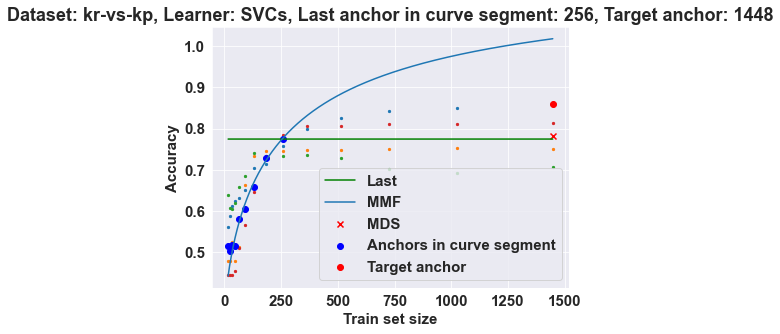

In [10]:
PlotCurveAndPrediction(0,3,8,12, legend = True)
#plt.savefig('../Plots/Paper/predictions.pdf', dpi=300, bbox_inches='tight')

## Aggregation 1 (Fixed curve segment and fixed target)
We show this only for the binary prediction objective and only for the binary error.

C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\1501730530.py:9: RuntimeWarning: Mean of empty slice
  MDS_vs_MMF = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(MMF_Agg1 - actual_Agg1), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\1501730530.py:10: RuntimeWarning: Mean of empty slice
  MDS_vs_Last = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\1501730530.py:11: RuntimeWarning: Mean of empty slice
  MMF_vs_Last = np.nanmean(np.abs(MMF_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\1501730530.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


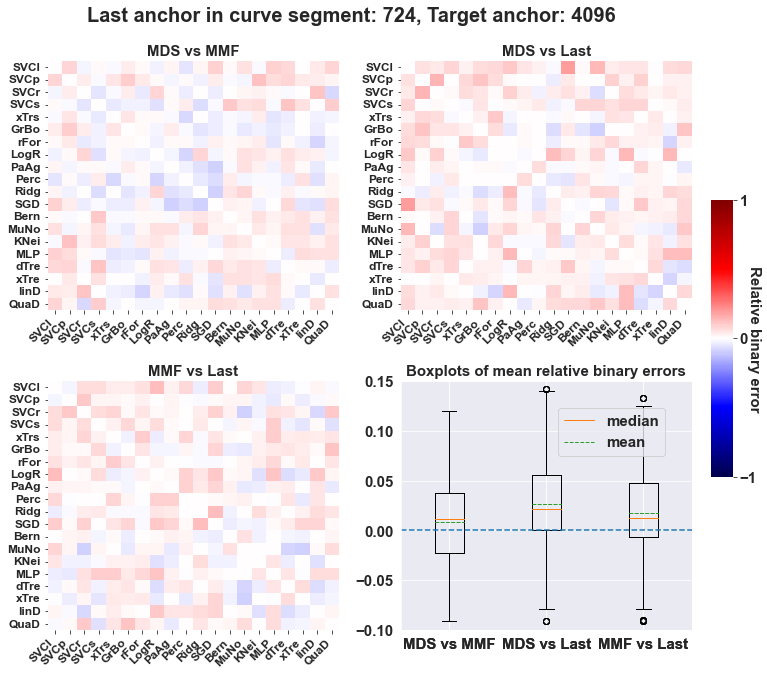

In [15]:
Win = -5
Target = -1

MDS_Agg1 = MDSbinary[:,:,:,Win,Target]
MMF_Agg1 = MMF[:,:,:,Win,Target]
Last_Agg1 = Last[:,:,:,Win,Target]
actual_Agg1 = actual[:,:,:,Win,Target]

MDS_vs_MMF = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(MMF_Agg1 - actual_Agg1), axis=0)
MDS_vs_Last = np.nanmean(np.abs(MDS_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)
MMF_vs_Last = np.nanmean(np.abs(MMF_Agg1 - actual_Agg1) - np.abs(Last_Agg1 - actual_Agg1), axis=0)

#diagonals to 0
np.fill_diagonal(MDS_vs_MMF, 0)
np.fill_diagonal(MDS_vs_Last, 0)
np.fill_diagonal(MMF_vs_Last, 0)


title = ('Last anchor in curve segment: {}, Target anchor: {}'.format(win.train_anchors[Win],win.target_anchors[Target]))
fig, ax = plt.subplots(2, 2, figsize = (5*2,4.8*2))

# make a new colorbar axis
cbar_ax = fig.add_axes([1, .3, .03, .4])


sns.heatmap(MDS_vs_MMF, vmin=-1, vmax=1, cmap='seismic', ax = ax[0,0], cbar_ax = None, cbar = False)
ax[0,0].set_title('MDS vs MMF', fontsize=15, fontweight='bold')
ax[0,0].tick_params(left=True, bottom=True)

sns.heatmap(MDS_vs_Last, vmin=-1, vmax=1, cmap='seismic', ax = ax[0,1], cbar_ax = None, cbar = False)
ax[0,1].set_title('MDS vs Last', fontsize=15, fontweight='bold')
ax[0,1].tick_params(left=True, bottom=True)

sns.heatmap(MMF_vs_Last, vmin=-1, vmax=1, cmap='seismic', ax = ax[1,0], cbar_ax=cbar_ax, cbar_kws={'label': 'Relative binary error', 'orientation': 'vertical', 'ticks': [-1, 0, 1]})
ax[1,0].set_title('MMF vs Last', fontsize=15, fontweight='bold')
ax[1,0].tick_params(left=True, bottom=True)
cbar_ax.yaxis.label.set_size(15)
cbar_ax.yaxis.label.set_weight('bold')
cbar_ax.yaxis.label.set_rotation(270)

# set tick labels
ticks = np.arange(len(Slearners)) + 0.5
#index = [np.arange(0, len(Slearners), 3).astype(int), np.arange(1, len(Slearners), 3), np.arange(2, len(Slearners), 3)]
#index = [np.arange(0, len(Slearners),2), np.arange(1, len(Slearners), 2)]
Slearners = np.array(Slearners)
for i,id in enumerate([(0,0), (0,1), (1,0)]):
    # ax[id].set_xticks(ticks[index[0]])
    # ax[id].set_yticks(ticks[index[1]])
    ax[id].set_yticks(ticks)
    ax[id].set_xticks(ticks)
    # ax[id].set_yticklabels(Slearners[index[0]], rotation=0, fontsize=12, fontweight='bold')
    # ax[id].set_xticklabels(Slearners[index[1]], rotation=45, fontsize=12, fontweight='bold', ha='right')
    ax[id].set_yticklabels(Slearners, rotation=0, fontsize=12, fontweight='bold')
    ax[id].set_xticklabels(Slearners, rotation=45, fontsize=12, fontweight='bold', ha='right')


bplots = [MDS_vs_MMF[~np.isnan(MDS_vs_MMF)].ravel(), MDS_vs_Last[~np.isnan(MDS_vs_Last)].ravel(), MMF_vs_Last[~np.isnan(MMF_vs_Last)].ravel()]
ax[1,1].boxplot(bplots, labels=['MDS vs MMF', 'MDS vs Last', 'MMF vs Last'], showmeans=True, meanline=True)
bp = ax[1,1].boxplot(bplots, labels=['MDS vs MMF', 'MDS vs Last', 'MMF vs Last'], showmeans=True, meanline=True)
ax[1,1].axhline(0,linestyle='--')
ax[1,1].set_ylim([-0.1,0.15])
ax[1,1].set_title('Boxplots of mean relative binary errors', fontsize=15, fontweight='bold')

# legend
ax[1,1].legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'], loc = (0.54,0.7))

plt.suptitle(title, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig('Plots/Paper/Agg1.png', dpi=300, bbox_inches='tight')

## Aggregation 2 (Moving curve segment and fixed target)

In [16]:
# Get individual errors
MDS_error = np.nanmean(np.abs(MDSbinary - actual),axis=0)
MMF_error = np.nanmean(np.abs(MMF - actual), axis=0)
Last_error = np.nanmean(np.abs(Last - actual), axis=0)

# Same for regret / risk
Mean_MDSregret = np.nanmean(MDSregret, axis=0)
Mean_MMFregret = np.nanmean(MMFregret, axis=0)
Mean_Lastregret = np.nanmean(Lastregret, axis=0)

# Same for regression, absolute error
KaveragesMMF = np.nanmean(kMMF, axis = 0)
KaveragesMDS = np.nanmean(kMDS, axis = 0)
KaveragesLast = np.nanmean(kLast, axis = 0)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\2578957212.py:2: RuntimeWarning: Mean of empty slice
  MDS_error = np.nanmean(np.abs(MDSbinary - actual),axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\2578957212.py:3: RuntimeWarning: Mean of empty slice
  MMF_error = np.nanmean(np.abs(MMF - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\2578957212.py:4: RuntimeWarning: Mean of empty slice
  Last_error = np.nanmean(np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\2578957212.py:7: RuntimeWarning: Mean of empty slice
  Mean_MDSregret = np.nanmean(MDSregret, axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\2578957212.py:8: RuntimeWarning: Mean of empty slice
  Mean_MMFregret = np.nanmean(MMFregret, axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\2578957212.py:9: RuntimeWarning: Mean of empty slice
  Mean_Lastregret = np.nanmean(Lastregret, axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\2578957212.py:12: 

In [17]:
# Get relative errors
MDSvsMMF = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=0)
MMFvsLast = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=0)
MDSvsLast = np.nanmean(np.abs(MDSbinary - actual) - np.abs(Last - actual), axis=0)

# Regret / risk
MDSregretvsMMFregret = np.nanmean(MDSregret - MMFregret, axis=0)
MMFregretvsLastregret = np.nanmean(MMFregret - Lastregret, axis=0)
MDSregretvsLastregret = np.nanmean(MDSregret - Lastregret, axis=0)


# Regression, absolute error
KaveragesMDSvsMMF = np.nanmean(kMDS - kMMF, axis = 0)
KaveragesMDSvsLast = np.nanmean(kMDS - kLast, axis = 0)
KaveragesMMFvsLast = np.nanmean(kMMF - kLast, axis = 0)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\3996366466.py:2: RuntimeWarning: Mean of empty slice
  MDSvsMMF = np.nanmean(np.abs(MDSbinary - actual) - np.abs(MMF - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\3996366466.py:3: RuntimeWarning: Mean of empty slice
  MMFvsLast = np.nanmean(np.abs(MMF - actual) - np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\3996366466.py:4: RuntimeWarning: Mean of empty slice
  MDSvsLast = np.nanmean(np.abs(MDSbinary - actual) - np.abs(Last - actual), axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\3996366466.py:7: RuntimeWarning: Mean of empty slice
  MDSregretvsMMFregret = np.nanmean(MDSregret - MMFregret, axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\3996366466.py:8: RuntimeWarning: Mean of empty slice
  MMFregretvsLastregret = np.nanmean(MMFregret - Lastregret, axis=0)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_1832\3996366466.py:9: RuntimeWarning: Mean of empty slice
  MDS

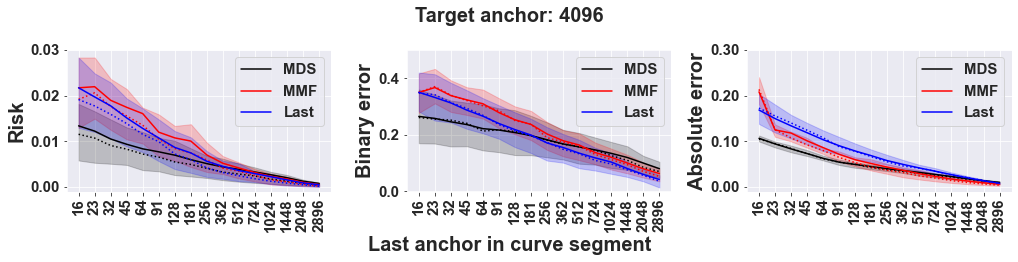

In [32]:
plots = {}
Target = -1
if Target != -1:
    ind = range(len(win.train_anchors))[:Target + 1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): Mean_MDSregret[..., i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): Mean_MMFregret[..., i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Mean_Lastregret[..., i, Target] for i in ind}

# plots2 = {}
# if Target != -1:
#     ind = range(len(win.train_anchors))[:Target + 1]
# else:
#     ind = range(len(win.train_anchors))
# plots2['MDS vs MMF'] = {str(win.train_anchors[i]): MDSregretvsMMFregret[..., i, Target] for i in ind}
# plots2['MDS vs Last'] = {str(win.train_anchors[i]): MDSregretvsLastregret[..., i, Target] for i in ind}
# plots2['MMF vs Last'] = {str(win.train_anchors[i]): MMFregretvsLastregret[..., i, Target] for i in ind}

# ylim2 = (-0.02, 0.01)
# hline2 = 0
# legend_loc2 = 'lower right'

title = 'Target anchor: {}'.format(win.target_anchors[Target])
ylim = (-0.001, 0.03)
figsize = (1.5*1.5, 1*1.5)
xlabel = 'Last anchor in window'
ylabel1 = 'Mean risk'
Q1Q3 = True
median = True
save = 'Plots\Paper\Agg2.pdf'
dpi = 300
xrot = False
col = ['black', 'red', 'blue', 'green']
legend_loc = 'upper right'
Q1Q3 = True
median = True
ls = '--'
hline = 'N'

plotlabels = list(plots.keys())
# plotlabels2 = list(plots2.keys())
w, h = *figsize,
fig, ax = plt.subplots(1, 3, figsize=(6.4 * w, 2.4 * h))
if ylim:
    ax[0].set_ylim(*ylim)
    # ax[1][0].set_ylim(*ylim2)
#if ylabel:
#    ax[0][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#    ax[1][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#if xlabel:
#    ax[1][0].set_xlabel(xlabel, fontsize=20, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

# ax[1][0].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=1, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        # labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        # labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    # data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    # means2 = [np.mean(dat) for dat in data2]

    ax[0].plot(means, c=c, label=plotlabels[i])
    # ax[1][0].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        # medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[0].plot(medians, c=c, linestyle='dotted')
        # ax[1][0].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        # q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        # q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[0].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        # ax[1][0].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[0].set_xticks(pos)
# ax[1][0].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[0].set_xticklabels(labels, rotation=90)
    # ax[1][0].set_xticklabels(labels[1::2], rotation=45, ha='right')
    ax[0].tick_params(left=True, bottom=True)
    # ax[1][0].tick_params(left=True, bottom=True)
if n_dicts != 1:
    ax[0].legend(loc=legend_loc)
    # ax[1][0].legend(loc=legend_loc2)


#Plot 2
plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))
plots['MDS'] = {str(win.train_anchors[i]): MDS_error[...,i, Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): MMF_error[...,i, Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): Last_error[...,i, Target] for i in ind}


# plots2 = {}
# if Target != -1:
#     ind = range(len(win.train_anchors))[:Target+1]
# else:
#     ind = range(len(win.train_anchors))
# plots2['MDS vs MMF'] = {str(win.train_anchors[i]): MDSvsMMF[...,i, Target] for i in ind}
# plots2['MDS vs Last'] = {str(win.train_anchors[i]): MDSvsLast[...,i, Target] for i in ind}
# plots2['MMF vs Last'] = {str(win.train_anchors[i]): MMFvsLast[...,i, Target] for i in ind}

ylim = (-0.001, 0.5)
# ylim2 = (-0.2,0.15)


if ylim:
    ax[1].set_ylim(*ylim)
    # ax[1][1].set_ylim(*ylim2)
#if ylabel:
#    ax[0][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#    ax[1][0].set_ylabel(ylabel, fontsize=20, fontweight='bold')
#if xlabel:
#    ax[1][0].set_xlabel(xlabel, fontsize=20, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

# ax[1][1].axhline(hline2, linestyle=ls)

if title:
    fig.suptitle(title, y=0.9, fontsize=20, fontweight='bold')

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        # labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        # labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    # data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    # means2 = [np.mean(dat) for dat in data2]

    ax[1].plot(means, c=c, label=plotlabels[i])
    # ax[1][1].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        # medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[1].plot(medians, c=c, linestyle='dotted')
        # ax[1][1].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        # q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        # q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[1].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        # ax[1][1].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[1].set_xticks(pos)
# ax[1][1].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[1].set_xticklabels(labels, rotation=90)
    # ax[1][1].set_xticklabels(labels[1::2], rotation=45, ha='right')
    # enable tick lines
    ax[1].tick_params(left=True, bottom=True)
    # ax[1][1].tick_params(left=True, bottom=True)
if n_dicts != 1:
    ax[1].legend(loc=legend_loc)
    # ax[1][1].legend(loc=legend_loc2)




#Plot 3
Target = -1

plots = {}
if Target != -1:
    ind = range(len(win.train_anchors))[:Target+1]
else:
    ind = range(len(win.train_anchors))

plots['MDS'] = {str(win.train_anchors[i]): KaveragesMDS[:,i,Target] for i in ind}
plots['MMF'] = {str(win.train_anchors[i]): KaveragesMMF[:,i,Target] for i in ind}
plots['Last'] = {str(win.train_anchors[i]): KaveragesLast[:,i,Target] for i in ind}


# plots2 = {}
# if Target != -1:
#     ind = range(len(win.train_anchors))[:Target+1]
# else:
#     ind = range(len(win.train_anchors))
# 
# plots2['MDS vs MMF'] = {str(win.train_anchors[i]): KaveragesMDSvsMMF[:,i,Target] for i in ind}
# plots2['MDS vs Last'] = {str(win.train_anchors[i]): KaveragesMDSvsLast[:,i,Target] for i in ind}
# plots2['MMF vs Last'] = {str(win.train_anchors[i]): KaveragesMMFvsLast[:,i,Target] for i in ind}


# ylim2 = (-0.12,0.05)
# hline2 = 0
# legend_loc2 = 'lower right'

ylim = (-0.01,0.3)
xlabel='Last anchor in curve segment'
ylabel2='Mean difference in absolute error'
Q1Q3=True
median=True
legend_loc='upper right'
ls='--'
hline = 'N'


plotlabels = list(plots.keys())
# plotlabels2 = list(plots2.keys())
if ylim:
    ax[2].set_ylim(*ylim)
    # ax[1][2].set_ylim(*ylim2)
#if ylabel:
#    ax[0][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#    ax[1][1].set_ylabel(ylabel, fontsize=15, fontweight='bold')
#if xlabel:
#    ax[1][1].set_xlabel(xlabel, fontsize=15, fontweight='bold')
if hline != 'N':
    plt.axhline(hline, linestyle=ls)

# ax[1][2].axhline(hline2, linestyle=ls)

n_dicts = len(plots)
if type(plots[plotlabels[0]]) != dict:
    n_dicts = 1
for i in range(n_dicts):
    c = col[i]
    if n_dicts == 1:
        labels, data = [*zip(*plots.items())]
        # labels2, data2 = [*zip(*plots2.items())]
    else:
        labels, data = [*zip(*plots[plotlabels[i]].items())]
        # labels2, data2 = [*zip(*plots2[plotlabels2[i]].items())]
    data = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data]
    means = [np.mean(dat) for dat in data]

    # data2 = [np.array(dat)[~np.isnan(np.array(dat))] for dat in data2]
    # means2 = [np.mean(dat) for dat in data2]

    ax[2].plot(means, c=c, label=plotlabels[i])
    # ax[1][2].plot(means2, c=c, label=plotlabels2[i])
    #dotted line
    if median:
        medians = [np.quantile(dat, 0.5) for dat in data]
        # medians2 = [np.quantile(dat, 0.5) for dat in data2]

        ax[2].plot(medians, c=c, linestyle='dotted')
        # ax[1][2].plot(medians2, c=c, linestyle='dotted')
    if Q1Q3:
        q1s = [np.quantile(dat, 0.25) for dat in data]
        q3s = [np.quantile(dat, 0.75) for dat in data]
        # q1s2 = [np.quantile(dat, 0.25) for dat in data2]
        # q3s2 = [np.quantile(dat, 0.75) for dat in data2]

        ax[2].fill_between(range(len(labels)), q1s, q3s, alpha=0.2, color=c)
        # ax[1][2].fill_between(range(len(labels)), q1s2, q3s2, alpha=0.2, color=c)
pos = np.arange(0, len(labels))
ax[2].set_xticks(pos)
# ax[1][2].set_xticks(pos[1::2])
if xrot:
    ax.set_xticklabels(labels, rotation=45, ha='right')
else:
    ax[2].set_xticklabels(labels, rotation=90)
    # ax[1][2].set_xticklabels(labels[1::2], rotation=45, ha='right')
    #enable tick lines
    ax[2].tick_params(bottom=True, left = True)
    # ax[1][2].tick_params(bottom=True, left = True)
if n_dicts != 1:
    ax[2].legend(loc=legend_loc)
    # ax[1][2].legend(loc=legend_loc2)


#if save:
fig.suptitle(title, y=0.90, fontsize=25, fontweight='bold')
# ax[1][0].yaxis.set_major_locator(plt.MaxNLocator(3))

# Common labels
fig.text(0.5, -0.01, xlabel, ha='center', fontsize=20, fontweight='bold')
#fig.text(0, 0.5, ylabel1, va='center', rotation='vertical', fontsize=20, fontweight='bold')
#fig.text(0.99, 0.5, ylabel2, va='center', rotation=270, fontsize=20, fontweight='bold')

# per plot labels
ax[1].set_ylabel('Binary error', fontsize=20, fontweight='bold')
# ax[1][1].set_ylabel('Relative binary error', fontsize=20, fontweight='bold')
ax[0].set_ylabel('Risk', fontsize=20, fontweight='bold')
# ax[1][0].set_ylabel('Relative risk', fontsize=20, fontweight='bold')
ax[2].set_ylabel('Absolute error', fontsize=20, fontweight='bold')
# ax[1][2].set_ylabel('Relative absolute error', fontsize=20, fontweight='bold')

from matplotlib.ticker import FormatStrFormatter
# set yaxis labels to be 2 decimals
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()

if title:
    fig.suptitle(title, y=0.93, fontsize=20, fontweight='bold')

plt.savefig(save, dpi=dpi, bbox_inches='tight')


plt.show()

## Aggregation 3 (Moving curve segments and targets)

In [26]:
# Averages for heatmap
averagesMDSvsMMF = np.nanmean(MDSvsMMF, axis=(0,1))
averagesMMFvsLast = np.nanmean(MMFvsLast, axis=(0,1))
averagesMDSvsLast = np.nanmean(MDSvsLast, axis=(0,1))

#For regret
regretAveragesMDSvsMMF = np.nanmean(MDSregretvsMMFregret, axis=(0,1))
regretAveragesMDSvsLast = np.nanmean(MDSregretvsLastregret, axis=(0,1))
regretAveragesMMFvsLast = np.nanmean(MMFregretvsLastregret, axis=(0,1))

# Regression, absolute error
KmeanaveragesMDSvsMMF = np.nanmean(KaveragesMDSvsMMF, axis = 0)
KmeanaverageMDSvsLast = np.nanmean(KaveragesMDSvsLast, axis = 0)
KmeanaveragesMMFvsLast = np.nanmean(KaveragesMMFvsLast, axis = 0)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\109722519.py:2: RuntimeWarning: Mean of empty slice
  averagesMDSvsMMF = np.nanmean(MDSvsMMF, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\109722519.py:3: RuntimeWarning: Mean of empty slice
  averagesMMFvsLast = np.nanmean(MMFvsLast, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\109722519.py:4: RuntimeWarning: Mean of empty slice
  averagesMDSvsLast = np.nanmean(MDSvsLast, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\109722519.py:7: RuntimeWarning: Mean of empty slice
  regretAveragesMDSvsMMF = np.nanmean(MDSregretvsMMFregret, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\109722519.py:8: RuntimeWarning: Mean of empty slice
  regretAveragesMDSvsLast = np.nanmean(MDSregretvsLastregret, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\109722519.py:9: RuntimeWarning: Mean of empty slice
  regretAveragesMMFvsLast = np.nanmean(MMFregretvsLastregret, axis=(0,1))
C:

C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\4248893756.py:102: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_19816\4248893756.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


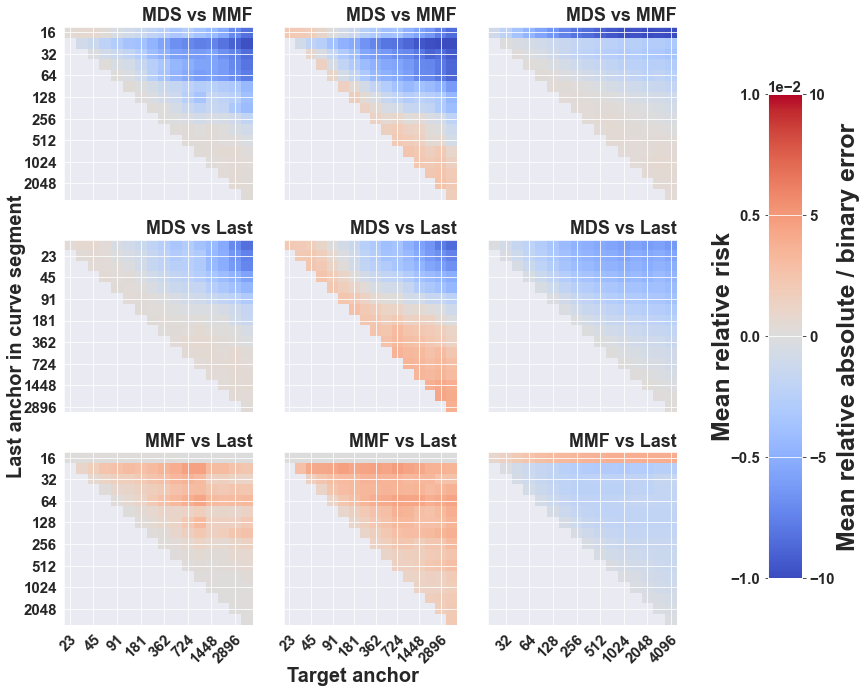

In [30]:
# w = 2
# h = 3.5
w, h = (1.5, 2)
fig, ax = plt.subplots(3,3, figsize=(6.4 * w, 4.8 * h))


a = ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[1][0].imshow(regretAveragesMDSvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[2][0].imshow(regretAveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')


b = ax[0][1].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[2][1].imshow(averagesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[1][1].imshow(averagesMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)

# set title
ax[0][0].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][0].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][0].set_title('MDS vs Last', weight = 'bold', loc='right')

ax[0][1].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][1].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][1].set_title('MDS vs Last', weight = 'bold', loc='right')

ax[0][2].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][2].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][2].set_title('MDS vs Last', weight = 'bold', loc='right')

c = ax[0][2].imshow(KmeanaveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')
ax[1][2].imshow(KmeanaverageMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')
ax[2][2].imshow(KmeanaveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')

# set (tick) labela
sl = slice(0, len(win.target_anchors), 2)
sl2 = slice(1, len(win.target_anchors), 2)

for i in range(3):
    ax[i][0].set_xticks(np.arange(len(win.target_anchors))[sl])
    ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][0].set_xticklabels(win.target_anchors[sl])
    ax[i][0].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax[i][1].set_xticks(np.arange(len(win.target_anchors))[sl])
    ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][1].set_xticklabels(win.target_anchors[sl])
    ax[i][1].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][1].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    ax[i][2].set_xticks(np.arange(len(win.target_anchors))[sl2])
    ax[i][2].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][2].set_xticklabels(win.target_anchors[sl2])
    ax[i][2].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # if i is 1 or 2
    if i == 1 or i == 0:
        ax[i][0].xaxis.set_ticklabels([])
        ax[i][1].xaxis.set_ticklabels([])
        ax[i][2].xaxis.set_ticklabels([])


    if i == 1:
        ax[i][2].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][2].set_yticklabels(win.train_anchors[sl2])
        ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][0].set_yticklabels(win.train_anchors[sl2])
        ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][1].set_yticklabels(win.train_anchors[sl2])

    ax[i][1].yaxis.set_ticklabels([])
    ax[i][2].yaxis.set_ticklabels([])

# set colorbar for all subplots the same
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
#cb = fig.colorbar(ax[0][0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
#cb.set_label(label = 'Mean difference in binary / absolute error', weight = 'bold', labelpad=-90, size = 25)

# dividers
plots = [a,b,c]
# for i in range(3):
#     divider = make_axes_locatable(ax[1][i])
#     cax = divider.append_axes('right', size='5%')
#     cb = fig.colorbar(plots[i], cax=cax, orientation='vertical')
#     tick_locator = ticker.MaxNLocator(nbins=4)
#     cb.locator = tick_locator
#     cb.formatter.set_powerlimits((0, 0))
#     cb.update_ticks()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
cb.set_label(label = 'Mean relative risk', weight = 'bold', labelpad=-90, size = 25)

pos = cb.ax.get_position()
cb.ax.set_aspect('auto')
ax2 = cb.ax.twinx()
ax2.set_ylim([-0.01*1000, 0.01*1000])
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
#ax2.yaxis.set_major_formatter(plt.set_powerlimits((0, 0)))

tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

cb.formatter.set_powerlimits((0, 0))

fig.text(0.5, 0, "Target anchor", ha='center', fontsize=20, fontweight='bold')
fig.text(0, 0.5, "Last anchor in curve segment", va='center', rotation='vertical', fontsize=20, fontweight='bold')
fig.text(1.2, 0.5, "Mean relative absolute / binary error", va='center', rotation=90, fontsize=25, fontweight='bold')
fig.tight_layout()
path = '..\Plots\Paper\Agg3.pdf'
#plt.savefig(path, dpi=300, bbox_inches='tight')